In [1]:
# imports and loading
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import mplcursors
from matplotlib.colors import Normalize

# load the stationary data
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
starve_metabs = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_metabolites_data.csv', index_col = 0)

# load pathway enrichment data
f = open('../data/KEGG/pathways.txt', 'r')
lines = f.readlines()
f.close()
pathway_to_desc = {}
for line in lines:
    pathway = line.split('\t')[0]
    desc = line.split('\t')[1].split(' - Escher')[0]
    pathway_to_desc.update({pathway : desc})
f = open('../data/KEGG/pathway_to_gene.txt', 'r')
lines = f.readlines()
f.close()
gene_to_pathway = {}
pathway_to_genes = {}
for line in lines:
    pathway = line.split('\t')[0].split('path:')[1]
    gene = line.split('\t')[1].split('eco:')[1].split('\n')[0]
    gene_to_pathway.update({gene : pathway})
    if pathway not in pathway_to_genes:
        pathway_to_genes.update({pathway : []})
    pathway_to_genes[pathway].append(gene)

# load TRN network data (TRN_df was created for TF KALE, I'm just copying it here, rows are regulators with 1's in the column being promoter of said gene and -1 being repressor)
TRN_df = pd.read_pickle('../data/regulonDB_files/TRN_df.pkl')
# TRN_df.loc['b3357']['b0908'] = -1, meaning b3357 represses b0908

# work by hand
pathways_with_metabolic_data = {
    'eco00051': 'Fructose and mannose metabolism',
    'eco00250': 'Alanine, aspartate and glutamate metabolism',
    'eco00260': 'Glycine, serine and threonine metabolism',
    'eco00270': 'Cysteine and methionine metabolism',
    'eco00280': 'Valine, leucine and isoleucine degradation',
    'eco00290': 'Valine, leucine and isoleucine biosynthesis',
    'eco00300': 'Lysine biosynthesis',
    'eco00310': 'Lysine degradation',
    'eco00220': 'Arginine biosynthesis',
    'eco00330': 'Arginine and proline metabolism',
    'eco00340': 'Histidine metabolism',
    'eco00350': 'Tyrosine metabolism',
    'eco00360': 'Phenylalanine metabolism',
    'eco00380': 'Tryptophan metabolism',
    'eco00410': 'beta-Alanine metabolism',
}

In [4]:
# let's first look at which pathways have few regulators
pathway_to_skew = {}
pathway_to_df = {}
pathway_to_dist = {}
for pathway in pathway_to_genes.keys():
# let's find the regulators of all of the genes involved
    overlap = list(set(TRN_df.columns).intersection(pathway_to_genes[pathway]))
    regulators = TRN_df.index[abs(TRN_df[overlap]).sum(axis = 1) != 0]
    baby = TRN_df.loc[regulators][overlap] # regulation of the pathway
    
    if len(regulators) == 0 or len(overlap) == 0:
        continue
    pathway_to_df.update({pathway : baby.copy()})
    
    # I want to figure out the top regulators of this group
    # filter out regulators that only regulate <= 20% of the genes
    high_targets = baby.index[abs(baby).sum(axis = 1) >= 0.20*len(baby.columns)]
    pathway_to_skew.update({pathway : scipy.stats.skew(abs(baby).sum(axis = 1))})
    
    # distance between top and bottom
    vals = abs(baby.sum(axis = 1)).sort_values(ascending = False)[0:2]
    try:
        dist = (vals[0] - vals[1]) / len(baby.columns)
        pathway_to_dist.update({pathway : dist})
    except:
        pathway_to_dist.update({pathway : 0})

/tmp/ipykernel_2507930/2698890269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pathway_to_skew.update({pathway : scipy.stats.skew(abs(baby).sum(axis = 1))})
/tmp/ipykernel_2507930/2698890269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pathway_to_skew.update({pathway : scipy.stats.skew(abs(baby).sum(axis = 1))})
/tmp/ipykernel_2507930/2698890269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  pathway_to_skew.update({pathway : scipy.stats.skew(abs(baby).sum(axis = 1))})
/tmp/ipykernel_2507930/2698890269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic c

<IPython.core.display.Javascript object>


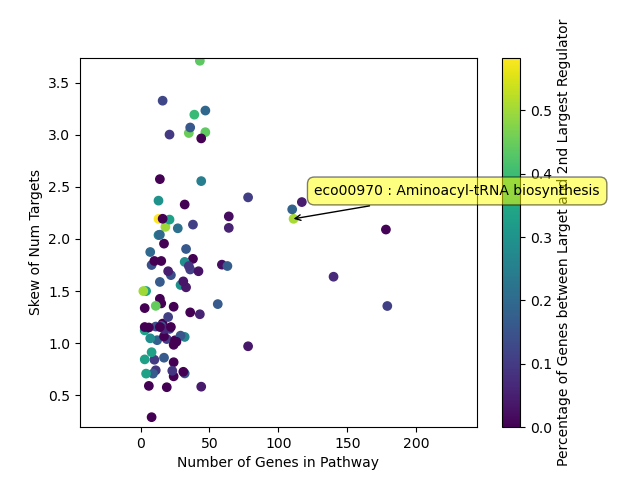

/tmp/ipykernel_2507930/1953957224.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Percentage of Genes between Larget and 2nd Largest Regulator')


In [5]:
# let's plot these
%matplotlib notebook

def map_value_to_color(value, vmin = 0, vmax = max(pathway_to_dist.values()), colormap_name = 'viridis'):
    # Normalize the value to be between 0 and 1
    normalized_value = (value - vmin) / (vmax - vmin)
    
    # Ensure the normalized value is within the [0, 1] range
    normalized_value = np.clip(normalized_value, 0, 1)
    
    # Get the colormap
    colormap = plt.get_cmap(colormap_name)
    
    # Map the normalized value to a color from the colormap
    color = colormap(normalized_value)
    
    # Convert the RGBA color to a hex representation
    hex_color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    
    return hex_color

sizes = []
skews = []
labels = []
colors = []
for path, skew in pathway_to_skew.items():
    skews.append(skew)
    sizes.append(len(pathway_to_genes[path]))
    colors.append(map_value_to_color(pathway_to_dist[path]))
    labels.append(path+' : '+pathway_to_desc[path])

fig, ax = plt.subplots()

scatter = ax.scatter(sizes, skews, c = colors)
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(labels[sel.target.index]))
ax.set_ylabel('Skew of Num Targets')
ax.set_xlabel('Number of Genes in Pathway')

# Create a ScalarMappable object for the color mapping
norm = Normalize(vmin=0, vmax=max(pathway_to_dist.values()))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Fake a normalization array

# Add colorbar
cbar = plt.colorbar(sm, label='Percentage of Genes between Larget and 2nd Largest Regulator')

plt.show()

In [2]:
# invstigating specific points of interest from plot above
promising_pathways = [
    'eco00220',
    'eco00061',
    'eco00541',
    'eco00300',
    'eco00051',
    'eco00052',
    'eco00520',
    'eco00040',
    'eco02060',
    'eco00600',
    'eco00785',
]

In [7]:
# FadR (eco00061) seems very interesting, acetyl-coA is the activator to fadR which promotes most of one regulon
pathway_to_genes['eco00061']

['b0180',
 'b0185',
 'b0954',
 'b1091',
 'b1092',
 'b1093',
 'b1095',
 'b1288',
 'b1805',
 'b2316',
 'b2323',
 'b3255',
 'b3256']

In [9]:
pathway_to_df['eco00061'].loc['b1187']

b3255    1
b2323    1
b1092    1
b1288    1
b0185    1
b3256    1
b0954    1
b1093    1
b1805   -1
b1091    1
b2316    1
b0180    0
Name: b1187, dtype: int64

In [3]:
starve_metabs.index

Index(['4N/AMethylN/A2N/Aoxovaleric acid (Ketoleucine)', 'AcetylN/ACoA',
       'Adenine', 'ADP', 'Alanine', 'AMP', 'Arginine', 'Argininosuccinic acid',
       'Asparagine', 'Aspartic acid', 'ATP', 'cAMP', 'CDP', 'Citrate',
       'Citrulline', 'CMP', 'Coenzyme A', 'CTP', 'Cytidine', 'Cytosine',
       'DN/AAlanylN/AAlanine', 'Diaminopimelic acid', 'Dihydroorotate',
       'DihydroxyacetoneN/AP', 'DN/APantothenic acid', 'Erythrose 4N/AP',
       'FructoseN/A1,6N/ABisphosphate', 'Fumarate', 'GABA', 'GDP',
       'Glutamic acid', 'Glutamine', 'Glycine', 'GMP', 'GTP', 'Guanine',
       'Guanosine', 'Histidine', 'Histidinol', 'Homoserine', 'Hypoxanthine',
       'IMP', 'Inosine', 'Leucine/Isoleucine', 'Lysine', 'Malate',
       'Methionine', 'NAD', 'NADH', 'NADP', 'NADPH', 'Orotate',
       'Oxidized glutathione', 'PentoseN/AP', 'Phenylalanine',
       'Phosphoenolpyruvate', 'Proline', 'Reduced glutathione',
       'Seduheptulose 7N/AP', 'Serine', 'Succinate', 'Tryptophan', 'Tyrosine',
   